## Prepare

### import packages

In [1]:
# package general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pprint

In [2]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# clean dataset
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

# skelarn  random forest
import sklearn.naive_bayes as sknb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# sklearn naive bayes
from sklearn.preprocessing import StandardScaler

In [4]:
sensing_data_path = '../dataset/sensing'
audio_path = sensing_data_path+'/audio/'
Data_path = '../Data/'

### audio data

In [3]:
# audio_u00 = pd.read_csv(audio_path+'/audio_u00.csv')

In [5]:
def clean_df(df):
    """ input: original dataframe.
        output: dataframe. Turn timestamp from unix time into readable time. and set index.
    """
    df.timestamp = pd.to_datetime(df.timestamp,unit='s')
    df.index  = df.timestamp
    return df

In [6]:
def get_fname(path):
    # get file name for all subfiles for the whole ukwac corpus.
    file = [f for f in os.listdir(path) if re.search('(.+\.csv$)', f)]
    file = sorted(file)
    return file

In [ ]:
def get_categorized_data():
    

In [158]:
# take a directory of user files into a frequency level time series.(mean)
% matplotlib inline
f_names = get_fname(audio_path)
audio_time_df = pd.DataFrame()

for user_f in f_names:
    
    audio_user = pd.read_csv(audio_path+user_f)
    
    audio_user = clean_df(audio_user)
    
    # group second data into days.
    weekly = audio_user[' audio inference'].resample('D').mean()
    
    # turn a series of data into a row(with dataframe type).
    weekly_transposed = weekly.to_frame(name=user_f.strip('.csv')).transpose()
    
    # add into final result
    audio_time_df = pd.concat([audio_time_df,weekly_transposed])

# weekly.plot(style = [':','--','-'])

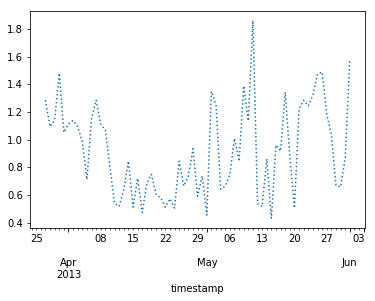

In [147]:
weekly.plot(style = [':','--','-'])

In [149]:
# audio_time_df

In [153]:
audio_time_df

timestamp,2013-03-27 00:00:00,2013-03-28 00:00:00,2013-03-29 00:00:00,2013-03-30 00:00:00,2013-03-31 00:00:00,2013-04-01 00:00:00,2013-04-02 00:00:00,2013-04-03 00:00:00,2013-04-04 00:00:00,2013-04-05 00:00:00,...,2013-05-24 00:00:00,2013-05-25 00:00:00,2013-05-26 00:00:00,2013-05-27 00:00:00,2013-05-28 00:00:00,2013-05-29 00:00:00,2013-05-30 00:00:00,2013-05-31 00:00:00,2013-06-01 00:00:00,type
audio_u00,0.749417,0.667864,0.932931,1.141726,0.983944,0.695710,0.991881,0.815208,0.657354,0.768395,...,0.976463,1.201843,0.453994,0.656321,0.733401,0.844155,1.145935,0.960368,1.088989,4
audio_u01,0.662584,0.886449,0.936333,0.707928,0.712645,0.976647,0.647392,0.811857,0.845189,0.809110,...,0.000000,0.834864,0.993270,0.883704,0.670391,0.651118,NaN,NaN,NaN,1
audio_u02,0.048722,0.432223,0.674008,0.714902,0.886738,0.751261,0.657706,0.197471,0.698145,0.487054,...,0.773614,0.892915,0.409230,0.564888,0.505921,0.928705,0.900223,0.867054,1.058422,3
audio_u03,0.409205,0.166914,0.381898,0.047826,0.026440,0.407944,0.010806,0.395711,0.022006,0.337063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
audio_u04,0.993878,0.964015,1.017597,0.863387,0.994029,0.951711,0.766351,0.965668,0.919020,0.980981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
audio_u05,0.751407,0.821564,0.747993,1.068005,0.690415,0.724879,0.731381,0.751538,0.951813,0.787095,...,0.596413,0.262843,0.444444,0.604333,0.818673,0.707760,NaN,NaN,NaN,1
audio_u07,0.850009,0.899389,0.782751,0.703444,0.629705,0.708954,0.956334,0.672418,0.988219,0.900905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
audio_u08,0.609390,0.641934,0.619931,0.589557,0.518667,0.864522,0.594564,0.604747,0.628014,0.949641,...,0.733727,0.640331,1.028166,0.823560,0.727032,0.783044,NaN,0.548387,NaN,-
audio_u09,0.541760,0.715219,0.839556,0.661574,0.239637,0.906788,0.754716,0.661459,0.817128,0.844103,...,0.868602,0.700736,0.980581,0.694315,0.457092,0.604875,0.829122,0.506452,NaN,2
audio_u10,0.618673,0.566999,0.657134,0.647579,0.396205,0.525891,0.681759,0.616444,0.688119,0.638125,...,0.707575,0.830346,0.868142,0.776488,0.775223,0.815153,0.629473,0.468575,0.063183,3


extract silence count(0) and voice count (conversation:1) and noisy environment(2) 

## Feature extration


In [ ]:
lock['weekday'] = lock['end'].apply(lambda x: datetime.utcfromtimestamp(x).weekday()) # Monday:0

### Split train & test dataset

#### import more X(feature) outside audio

In [173]:
lock_daily = pd.read_csv(Data_path+'lock_daily.csv')
sleep_time = pd.read_csv(Data_path+'sleep_time.csv')
lock_daily.index = lock_daily['date']
sleep_time.index = sleep_time['date']

In [269]:
ds_lock_daily = pd.read_csv(Data_path+'ds_lock_daily.csv', index_col = 0)

In [183]:
# lock_daily = lock_daily.drop(columns = ['date','weekday']).transpose()

In [190]:
# sleep_time.columns = [i + '-st' for i in sleep_time.columns]

In [192]:
# sleep_time.to_csv(Data_path+'sleep_time.csv', index = False)
# lock_daily.to_csv(Data_path+'lock_daily.csv', index = False)

In [184]:
# sleep_time = sleep_time.drop(columns = ['date','weekday']).transpose()

In [235]:
combined_time_df = pd.concat([audio_time_df, xiaohua], axis=1)


In [244]:
combined_time_df.to_csv(Data_path+'combined_time_df.csv')

In [261]:
combined_time_df = pd.read_csv(Data_path+'combined_time_df.csv', index_col = 0)

In [256]:
combined_time_df.columns[60:80]

Index(['2013-05-26 00:00:00', '2013-05-27 00:00:00', '2013-05-28 00:00:00',
       '2013-05-29 00:00:00', '2013-05-30 00:00:00', '2013-05-31 00:00:00',
       '2013-06-01 00:00:00', '2013-03-27-st', '2013-03-28-st',
       '2013-03-29-st', '2013-03-30-st', '2013-03-31-st', '2013-04-01-st',
       '2013-04-02-st', '2013-04-03-st', '2013-04-05-st', '2013-04-06-st',
       '2013-04-07-st', '2013-04-08-st', '2013-04-09-st'],
      dtype='object')

#### Add type column as Y

In [10]:
def str_ (num):
    if int(num)<10:
        return '0'+str(num)
    else:
        return str(num)

In [11]:
def map_id(id_):
    summary = pd.read_csv(Data_path+'summary_data.csv')
    dict_mapping = {}
    for i,each in summary.iterrows():
        dict_mapping[i] = each['uid'].strip('u')
    if id_ in dict_mapping:
        return dict_mapping[id_]
    else:
        return None

In [156]:
# id mapping between cluster id and user id 
# return dict: {cluster_id_1: 'user_id_1', ...}
id_map = {}
for each in cluster_user:
    id_map[each[0]] = map_id(each[0])
print(id_map)
    

{0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '07', 7: '09', 8: '10', 9: '14', 10: '15', 11: '16', 12: '17', 13: '18', 14: '19', 15: '20', 16: '23', 17: '24', 18: '27', 19: '30', 20: '31', 21: '32', 22: '33', 23: '34', 24: '35', 25: '36', 26: '42', 27: '43', 28: '44', 29: '45', 30: '47', 31: '49', 32: '51', 33: '52', 34: '53', 35: '56', 36: '58', 37: '59', 38: '46', 39: '54'}


In [154]:
cluster_user = [(0, 4), (1, 1), (2, 3), (3, 3), (4, 3), (5, 1), (6, 0), (7, 2), (8, 3), (9, 1), (10, 4), (11, 0), (12, 0), (13, 0), (14, 3), (15, 2), (16, 0), (17, 2), (18, 0), (19, 1), (20, 4), (21, 1), (22, 0), (23, 2), (24, 4), (25, 1), (26, 4), (27, 1), (28, 1), (29, 4), (30, 1), (31, 4), (32, 4), (33, 0), (34, 0), (35, 4), (36, 4), (37, 4), (38, 0), (39, 3)]
audio_time_df['type'] = '-'
for user in cluster_user:
    id_user = map_id(user[0])
    audio_time_df.at['audio_u'+id_user,'type'] = user[1]

In [198]:
# audio_time_df = audio_time_df[audio_time_df['type']!='-']

In [130]:
X_train, X_test, y_train, y_test = (
train_test_split(audio_time_df[audio_time_df.columns[:-1]],
                audio_time_df[audio_time_df.columns[-1]],
                test_size=0.2,
                random_state = 0))

print(len(X_train),len(X_test))

32 8


Deal with NaN

In [9]:
def fill_nan(x_train, strategy='mean'):
    # Create our imputer to replace missing values with the mean e.g.
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    imp = imp.fit(x_train)

    # Impute our data, then train
    X_train_imp = imp.transform(x_train)
    return X_train_imp

In [8]:
def change_type(y_train):
    return y_train.astype('float64')

In [131]:
X_train = fill_nan(X_train)
X_test = fill_nan(X_test)
y_train = change_type(y_train)
y_test = change_type(y_test)


In [133]:
print(reduced_X_test.shape)

(8, 8)


In [140]:
reduced_X_test = PCA(n_components = 10).fit_transform(X_test)
reduced_X_test.shape

(8, 8)

### do the same add Y and fill NA for combination data

In [238]:
cluster_user = [(0, 4), (1, 1), (2, 3), (3, 3), (4, 3), (5, 1), (6, 0), (7, 2), (8, 3), (9, 1), (10, 4), (11, 0), (12, 0), (13, 0), (14, 3), (15, 2), (16, 0), (17, 2), (18, 0), (19, 1), (20, 4), (21, 1), (22, 0), (23, 2), (24, 4), (25, 1), (26, 4), (27, 1), (28, 1), (29, 4), (30, 1), (31, 4), (32, 4), (33, 0), (34, 0), (35, 4), (36, 4), (37, 4), (38, 0), (39, 3)]
combined_time_df['type'] = '-'
for user in cluster_user:
    id_user = map_id(user[0])
    combined_time_df.at['audio_u'+id_user,'type'] = user[1]
combined_time_df = combined_time_df[combined_time_df['type']!='-']

In [271]:
cluster_user = [(0, 4), (1, 1), (2, 3), (3, 3), (4, 3), (5, 1), (6, 0), (7, 2), (8, 3), (9, 1), (10, 4), (11, 0), (12, 0), (13, 0), (14, 3), (15, 2), (16, 0), (17, 2), (18, 0), (19, 1), (20, 4), (21, 1), (22, 0), (23, 2), (24, 4), (25, 1), (26, 4), (27, 1), (28, 1), (29, 4), (30, 1), (31, 4), (32, 4), (33, 0), (34, 0), (35, 4), (36, 4), (37, 4), (38, 0), (39, 3)]
ds_lock_daily['type'] = '-'
for user in cluster_user:
    id_user = map_id(user[0])
    ds_lock_daily.at['deseasoned_hr_u'+id_user,'type'] = user[1]
ds_lock_daily = ds_lock_daily[ds_lock_daily['type']!='-']

In [262]:
sub_c  = [i for i in combined_time_df.columns if '-st' not in str(i) ] # +['type']
combined_time_df = combined_time_df[sub_c]

In [272]:
X_train_combine, X_test_combine, y_train_combine, y_test_combine = (
train_test_split(ds_lock_daily[ds_lock_daily.columns[:-1]],
                ds_lock_daily[ds_lock_daily.columns[-1]],
                test_size=0.2,
                random_state = 0))

In [273]:
X_train_combine = fill_nan(X_train_combine)
X_test_combine = fill_nan(X_test_combine)
y_train_combine = change_type(y_train_combine)
y_test_combine = change_type(y_test_combine)

#### lock_daily non_split, fill na

In [66]:
ds_lock_daily = pd.read_csv(Data_path+'ds_lock_daily.csv', index_col = 0)
cluster_user = [(0, 4), (1, 1), (2, 3), (3, 3), (4, 3), (5, 1), (6, 0), (7, 2), (8, 3), (9, 1), (10, 4), (11, 0), (12, 0), (13, 0), (14, 3), (15, 2), (16, 0), (17, 2), (18, 0), (19, 1), (20, 4), (21, 1), (22, 0), (23, 2), (24, 4), (25, 1), (26, 4), (27, 1), (28, 1), (29, 4), (30, 1), (31, 4), (32, 4), (33, 0), (34, 0), (35, 4), (36, 4), (37, 4), (38, 0), (39, 3)]
ds_lock_daily['type'] = '-'
for user in cluster_user:
    id_user = map_id(user[0])
    ds_lock_daily.at['deseasoned_hr_u'+id_user,'type'] = user[1]
ds_lock_daily = ds_lock_daily[ds_lock_daily['type']!='-']

# sub_c  = [i for i in ds_lock_daily.columns if '-ld' in str(i) ] +['type']
# ds_lock_daily = ds_lock_daily[sub_c]

# X_ld_whole = fill_nan(ds_lock_daily[ds_lock_daily.columns[:-1]])
user_mean = ds_lock_daily.mean(axis=1).to_dict()
X_ld_whole = ds_lock_daily.transpose().fillna(user_mean).transpose()
y_ld_whole = change_type(ds_lock_daily[ds_lock_daily.columns[-1]])


In [57]:
user_mean = ds_lock_daily.mean(axis=1).to_dict()
user_mean

{'deseasoned_hr_u00': 0.06451612903225834,
 'deseasoned_hr_u01': -0.31862596756809725,
 'deseasoned_hr_u02': -0.03497269303201428,
 'deseasoned_hr_u03': -0.12664648622981986,
 'deseasoned_hr_u04': -0.13876091893780587,
 'deseasoned_hr_u05': -0.15190178571428645,
 'deseasoned_hr_u07': 0.11165717736370011,
 'deseasoned_hr_u09': -0.1682371311989947,
 'deseasoned_hr_u10': -0.15798063520509764,
 'deseasoned_hr_u14': -0.14192643467643487,
 'deseasoned_hr_u15': 0.2359444444444441,
 'deseasoned_hr_u16': -0.1580213991769547,
 'deseasoned_hr_u17': 0.018004812722327162,
 'deseasoned_hr_u18': -0.18202380952381036,
 'deseasoned_hr_u19': -0.15945198340416883,
 'deseasoned_hr_u20': 0.05089506172839458,
 'deseasoned_hr_u23': 0.05910593850022853,
 'deseasoned_hr_u24': -0.08243727598566336,
 'deseasoned_hr_u27': -0.06868294051627395,
 'deseasoned_hr_u30': -0.2857936350466113,
 'deseasoned_hr_u31': 0.009730160598452395,
 'deseasoned_hr_u32': 0.015744984567901403,
 'deseasoned_hr_u33': 0.01362951092117722

In [65]:
ds_lock_daily.fillna(ds_lock_daily.mean()).head()

,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-05,2013-04-06,...,2013-05-20,2013-05-23,2013-05-24,2013-05-25,2013-05-26,2013-05-27,2013-05-28,2013-05-30,2013-05-31,type
deseasoned_hr_u00,0.347639,2.730000,0.592917,1.386493,-4.682099,-0.679568,3.999826,-4.265694,-0.593472,-10.747674,...,6.010710,3.002778,5.170139,6.617326,2.525401,-1.704012,-3.122118,2.255833,-4.040694,4
deseasoned_hr_u01,-0.672861,10.408796,-4.267593,-7.318730,-9.521865,-6.974236,1.419514,10.621306,7.599352,2.810437,...,0.524931,2.064630,6.890463,-1.523042,-5.125476,7.896319,-3.831597,1.753031,1.192489,1
deseasoned_hr_u02,-1.756778,-0.484656,-5.462139,0.555309,-1.761562,-3.072014,3.978056,-1.797611,3.310083,3.633642,...,-1.567292,-2.979198,-1.607139,-0.441080,0.380938,0.173819,4.916111,-2.517531,-0.044361,3
deseasoned_hr_u03,-12.986627,-0.550278,-1.236319,-9.256204,-3.145595,-5.585278,-2.347247,-1.386905,-2.380486,-1.002684,...,-0.759014,0.365344,1.185153,-1.523042,2.171870,1.532310,0.842966,1.753031,1.192489,3
deseasoned_hr_u04,1.527037,-1.383125,-2.765347,-8.552153,-7.053715,-4.898730,-3.069931,-6.231574,13.899375,11.476458,...,-0.759014,0.365344,1.185153,-1.523042,2.171870,1.532310,0.842966,1.753031,1.192489,3


In [62]:
ds_lock_daily.transpose().fillna(user_mean).transpose()

,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-05,2013-04-06,...,2013-05-20,2013-05-23,2013-05-24,2013-05-25,2013-05-26,2013-05-27,2013-05-28,2013-05-30,2013-05-31,type
deseasoned_hr_u00,0.347639,2.730000,0.592917,1.386493,-4.682099,-0.679568,3.999826,-4.265694,-0.593472,-10.747674,...,6.010710,3.002778,5.170139,6.617326,2.525401,-1.704012,-3.122118,2.255833,-4.040694,4.0
deseasoned_hr_u01,-0.672861,10.408796,-4.267593,-7.318730,-9.521865,-6.974236,1.419514,10.621306,7.599352,2.810437,...,0.524931,2.064630,6.890463,-0.318626,-5.125476,7.896319,-3.831597,-0.318626,-0.318626,1.0
deseasoned_hr_u02,-1.756778,-0.034973,-5.462139,0.555309,-1.761562,-3.072014,3.978056,-1.797611,3.310083,3.633642,...,-1.567292,-2.979198,-1.607139,-0.441080,0.380938,0.173819,4.916111,-2.517531,-0.044361,3.0
deseasoned_hr_u03,-12.986627,-0.550278,-1.236319,-9.256204,-3.145595,-5.585278,-0.126646,-1.386905,-2.380486,-0.126646,...,-0.126646,-0.126646,-0.126646,-0.126646,-0.126646,-0.126646,-0.126646,-0.126646,-0.126646,3.0
deseasoned_hr_u04,1.527037,-1.383125,-2.765347,-8.552153,-7.053715,-4.898730,-3.069931,-6.231574,13.899375,11.476458,...,-0.138761,-0.138761,-0.138761,-0.138761,-0.138761,-0.138761,-0.138761,-0.138761,-0.138761,3.0
deseasoned_hr_u05,-3.767000,-6.554063,-0.537431,-3.329213,-13.046065,-8.960123,-9.762593,-7.630889,2.335069,-4.398102,...,4.034877,-0.223785,6.551736,-0.151902,-0.151902,6.972654,6.007963,-0.151902,-0.151902,1.0
deseasoned_hr_u07,6.301065,-1.622619,14.596852,-3.519259,-8.091508,2.189722,-10.603452,-0.841157,-4.663148,-5.792315,...,0.111657,0.111657,0.111657,0.111657,0.111657,0.111657,0.111657,0.111657,0.111657,0.0
deseasoned_hr_u09,3.870806,-4.985806,-5.581250,4.036146,-0.168237,-0.168237,3.358519,1.902472,6.925417,-8.476632,...,-3.783889,-6.215806,-3.689861,2.463646,3.800357,0.448611,3.095463,10.867250,7.922917,2.0
deseasoned_hr_u10,-0.321639,-2.758417,-1.367583,-8.047556,-6.728549,-4.077191,-3.218117,-7.185528,-6.870083,-8.682000,...,3.188642,7.612139,0.802694,-5.182833,7.990617,-2.081914,-3.829506,5.813806,11.498806,3.0
deseasoned_hr_u14,-5.515111,-0.643214,-10.174563,-5.587639,-3.389444,-7.375069,-3.818646,-0.889833,1.007659,-9.885694,...,-1.214792,-0.141926,-0.141926,-0.141926,8.011389,-0.141926,9.896910,-0.141926,-0.141926,1.0


In [296]:
X_ld_whole.shape

(40, 61)

### PCA

In [141]:
reduced_X_train = PCA(n_components=8).fit_transform(X_train)
reduced_X_test = PCA(n_components=8).fit_transform(X_test)

## Random Forest

In [142]:
rf_model = RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(X_train_imp,y_train)
rf_pred_y = rf_model.predict(X_test)
accuracy_score(y_test, rf_pred_y)

0.25

### grid search

In [119]:
cv_rf_model =RandomForestClassifier(n_jobs=2,oob_score=True, criterion='entropy')

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [9, 11, 13, 15],
                 'max_features' :[2,3,5]
             }
grid_clf = GridSearchCV(cv_rf_model, param_grid, cv=5)
grid_clf.fit(X_train_imp,y_train)
# grid_clf.best_estimator_
# grid_clf.best_params_
grid_clf.score(X_test,y_test) # or : accuracy_score(test_y, grid_clf.predict(test_x))

0.25

In [121]:
grid_clf.best_params_

{'max_depth': 15, 'max_features': 2, 'n_estimators': 25}

In [122]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=2,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### Most important feature:

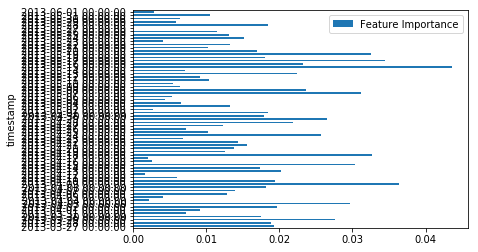

In [120]:
feat_importance = grid_clf.best_estimator_.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=audio_time_df.columns[:-1]).plot(kind='barh')

⬆️Need to design feature

## Naive bayes

In [146]:
# train the model
gnb_model = sknb.GaussianNB()
# given time series, predict cluster
gnb_model.fit(X_train,y_train)
# test the model
y_pred = gnb_model.predict(X_test)
gnb_model.score(X_test,y_test)

0.375

Try use PCA 

In [143]:
# train the model
gnb_model = sknb.GaussianNB()
# given sepal length, predict if setosa
gnb_model.fit(reduced_X_train,y_train)
# test the model
y_pred = gnb_model.predict(reduced_X_test)
gnb_model.score(reduced_X_test,y_test)

0.125

Adjust the data into standard scale

In [117]:
scaler = StandardScaler()
train_x_scale = scaler.fit_transform(X_train_imp)
test_x_scale =  scaler.fit_transform(X_test)
gnb_model_scale = sknb.GaussianNB()
# given sepal length, predict if setosa
gnb_model_scale.fit(train_x_scale,y_train)
# test the model
y_pred = gnb_model_scale.predict(test_x_scale)
gnb_model_scale.score(test_x_scale,y_test)

0.25

Try combined data with original nb

In [248]:
# train the model
gnb_model = sknb.GaussianNB()
# given time series, predict cluster
gnb_model.fit(X_train_combine,y_train_combine)
# test the model
y_pred = gnb_model.predict(X_test_combine)
gnb_model.score(X_test_combine,y_test_combine)

0.625

Cross validation shows that the score varies largely,

In [18]:
!pip3 show scikit-learn

Name: scikit-learn
Version: 0.20.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: numpy, scipy
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
gnb_model = sknb.GaussianNB()
for cv_score in [3,4,5,7,10]:
    score = cross_validate(gnb_model, X_ld_whole, y_ld_whole, scoring = 'accuracy',cv=cv_score)
    score_ = cross_val_score(gnb_model, X_ld_whole, y_ld_whole, scoring = 'accuracy',cv=cv_score)
    # cross_val_score# , return_estimator = True
    pprint.pprint([cv_score, np.mean(score['test_score']),np.mean(score_),score_, score['test_score']])

[3,
 0.24358974358974358,
 0.24358974358974358,
 array([0.33333333, 0.23076923, 0.16666667]),
 array([0.33333333, 0.23076923, 0.16666667])]
[4,
 0.24684343434343434,
 0.24684343434343434,
 array([0.33333333, 0.18181818, 0.22222222, 0.25      ]),
 array([0.33333333, 0.18181818, 0.22222222, 0.25      ])]
[5,
 0.2716666666666666,
 0.2716666666666666,
 array([0.4       , 0.125     , 0.375     , 0.125     , 0.33333333]),
 array([0.4       , 0.125     , 0.375     , 0.125     , 0.33333333])]
[7,
 0.30612244897959184,
 0.30612244897959184,
 array([0.5       , 0.25      , 0.14285714, 0.16666667, 0.25      ,
       0.5       , 0.33333333]),
 array([0.5       , 0.25      , 0.14285714, 0.16666667, 0.25      ,
       0.5       , 0.33333333])]
[10,
 0.3183333333333333,
 0.3183333333333333,
 array([0.33333333, 0.4       , 0.        , 0.2       , 0.        ,
       0.75      , 0.33333333, 0.        , 0.66666667, 0.5       ]),
 array([0.33333333, 0.4       , 0.        , 0.2       , 0.        ,
       0

In [67]:
def cross_val(X, y, k=5):
    num_student = X.shape[0]
    split_size = np.floor(num_student/k)
    print(split_size)
    
    cuts = []
    for i in range(num_student):

        if i%split_size == 0:
            cuts.append(i)
            
    cuts.append(num_student-1)
    
    # make splits
    splits_x = {} # 1: data, 2: data
    splits_y = {}
    for i in range(k):
        splits_x[i] = X.iloc[cuts[i]:cuts[i+1],:]
        splits_y[i] = y.iloc[cuts[i]:cuts[i+1],:]
        
        
    # cross validate
    for i, test_x in splits_x.items():
        train_j = [j_k for j_k,_ in splits_x.items() if j_k != i] 
        train_x = pd.DataFrame()
        train_y = pd.DataFrame()
        for j in train_j:
            train_x.append(splits_x[j],ignore_index=True)
            train_y.append(splits_y[j],ignore_index=True)
        
        test_y = splits_y[i]
        
        # NB code
        
        # train the model
        gnb_model = sknb.GaussianNB()
        
        # given time series, predict cluster
        gnb_model.fit(train_x,train_y)
        
        # test the model
        
        print(gnb_model.predict(test_x),test_y)
        
        
        

            
            
    
    #X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state = 0)
    # df.fillna(df.mean(axis=1))
    

In [37]:
X_ld_whole

,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-05,2013-04-06,...,2013-05-20,2013-05-23,2013-05-24,2013-05-25,2013-05-26,2013-05-27,2013-05-28,2013-05-30,2013-05-31,type
deseasoned_hr_u00,0.347639,2.730000,0.592917,1.386493,-4.682099,-0.679568,3.999826,-4.265694,-0.593472,-10.747674,...,6.010710,3.002778,5.170139,6.617326,2.525401,-1.704012,-3.122118,2.255833,-4.040694,4
deseasoned_hr_u01,-0.672861,10.408796,-4.267593,-7.318730,-9.521865,-6.974236,1.419514,10.621306,7.599352,2.810437,...,0.524931,2.064630,6.890463,NaN,-5.125476,7.896319,-3.831597,NaN,NaN,1
deseasoned_hr_u02,-1.756778,NaN,-5.462139,0.555309,-1.761562,-3.072014,3.978056,-1.797611,3.310083,3.633642,...,-1.567292,-2.979198,-1.607139,-0.441080,0.380938,0.173819,4.916111,-2.517531,-0.044361,3
deseasoned_hr_u03,-12.986627,-0.550278,-1.236319,-9.256204,-3.145595,-5.585278,NaN,-1.386905,-2.380486,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
deseasoned_hr_u04,1.527037,-1.383125,-2.765347,-8.552153,-7.053715,-4.898730,-3.069931,-6.231574,13.899375,11.476458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
deseasoned_hr_u05,-3.767000,-6.554063,-0.537431,-3.329213,-13.046065,-8.960123,-9.762593,-7.630889,2.335069,-4.398102,...,4.034877,-0.223785,6.551736,NaN,NaN,6.972654,6.007963,NaN,NaN,1
deseasoned_hr_u07,6.301065,-1.622619,14.596852,-3.519259,-8.091508,2.189722,-10.603452,-0.841157,-4.663148,-5.792315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
deseasoned_hr_u09,3.870806,-4.985806,-5.581250,4.036146,NaN,NaN,3.358519,1.902472,6.925417,-8.476632,...,-3.783889,-6.215806,-3.689861,2.463646,3.800357,0.448611,3.095463,10.867250,7.922917,2
deseasoned_hr_u10,-0.321639,-2.758417,-1.367583,-8.047556,-6.728549,-4.077191,-3.218117,-7.185528,-6.870083,-8.682000,...,3.188642,7.612139,0.802694,-5.182833,7.990617,-2.081914,-3.829506,5.813806,11.498806,3
deseasoned_hr_u14,-5.515111,-0.643214,-10.174563,-5.587639,-3.389444,-7.375069,-3.818646,-0.889833,1.007659,-9.885694,...,-1.214792,NaN,NaN,NaN,8.011389,NaN,9.896910,NaN,NaN,1


In [68]:
cross_val(X_ld_whole, y_ld_whole, k=5)

8.0


IndexingError: Too many indexers

In [275]:
gnb_model.predict(X_test_combine),y_test_combine

(array([0., 4., 1., 4., 4., 0., 4., 1.]), deseasoned_hr_u33    0.0
 deseasoned_hr_u31    4.0
 deseasoned_hr_u36    1.0
 deseasoned_hr_u04    3.0
 deseasoned_hr_u15    4.0
 deseasoned_hr_u20    2.0
 deseasoned_hr_u44    1.0
 deseasoned_hr_u16    0.0
 Name: type, dtype: float64)

Search for appropreate prior

In [124]:
# prior = [i/10 for i in range(1,10)]
# for p in prior:
#     gnb_model_scale = sknb.GaussianNB(priors = [p,1-p])
#     train_p = scaler.fit_transform(X_train_imp) # ,'SOURCE_APP_BYTES','REMOTE_APP_PACKETS'
#     gnb_model_scale.fit(train_p,y_train)
#     # test the mode
#     test_p = scaler.fit_transform(X_test)
#     y_pred = gnb_model_scale.predict(test_p)
#     print('prior:',[p,round(1-p,1)],'accuracy:',gnb_model_scale.score(test_p,test_y))